In [1]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1188 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease   
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3109 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [32.0 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1421 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [3046 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2896 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 

In [2]:
!git clone https://github.com/vislearn/ControlNet-XS

fatal: destination path 'ControlNet-XS' already exists and is not an empty directory.


In [3]:
!pip install -r ControlNet-XS/requirements/pt2.txt -qq
!pip install -e ControlNet-XS -qq

___

Restart kernel here, so newly installed packages are available

___

In [3]:
import scripts.control_utils as cu
import torch
from PIL import Image

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [4]:
path_to_config = 'ControlNet-XS/configs/inference/sdxl/sdxl_encD_canny_48m.yaml'

In [3]:
from omegaconf import OmegaConf

In [4]:
cfg = OmegaConf.load(path_to_config)

In [5]:
unet_path = cfg.model.params.ckpt_path
unet_path

'weights/sdxlvae/unet/diffusion_pytorch_model.safetensors'

In [6]:
from sgm.modules.diffusionmodules.twoStreamControl import TwoStreamControlNet

In [7]:
req_params = {
    p: cfg.model.params.network_config.params[p]    
    for p in ['in_channels', 'model_channels', 'out_channels', 'hint_channels', 'num_res_blocks', 'attention_resolutions', 'num_head_channels']
}
req_params

{'in_channels': 4,
 'model_channels': 320,
 'out_channels': 4,
 'hint_channels': 3,
 'num_res_blocks': 2,
 'attention_resolutions': [4, 2],
 'num_head_channels': 64}

In [8]:
empty_model = TwoStreamControlNet(**req_params)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 640, out-chn: 640, kernel-size: 3, stride: 2, padding: 1
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 1280, out-chn: 1280, kernel-size: 3, stride: 2, padding: 1
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 640, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 1280, out-chn: 640, kernel-size: 3, stride: 2, padding: 1
Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 2560, out-chn: 1280, kernel-size: 3, stride: 2, padding: 1


In [9]:
empty_model

TwoStreamControlNet(
  (control_model): ControlledXLUNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=320, out_features=1280, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): GroupNorm_leq32(32, 640, eps=1e-05, affine=True)
            (1): SiLU()
            (2): Conv2d(640, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (h_upd): Identity()
          (x_upd): Identity()
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=1280, out_features=320, bias=True)
          )
          (out_layers): Sequential(
            (0): GroupNorm_leq32(32, 320, eps=1e-05, affine=True)
     

In [10]:
from safetensors.torch import load_file as load_safetensors

In [11]:
from util import pretty_print_dict, print_as_nested_dict, print_as_nested_dict

In [12]:
state_dict = load_safetensors(unet_path)

This is what the unet weights contain:

In [13]:
print_as_nested_dict(state_dict, lv=1)

add_embedding
conv_in
conv_norm_out
conv_out
down_blocks
mid_block
time_embedding
up_blocks


In [14]:
missing, unexpected = empty_model.load_state_dict(state_dict, strict=False)

This is what the model didn't use from the provided unet weights

In [15]:
print_as_nested_dict(unexpected, lv=1)

add_embedding
conv_in
conv_norm_out
conv_out
down_blocks
mid_block
time_embedding
up_blocks


The model doesn't use **any**thing! This means the unet is not loaded at all. That's why the output of the model seem random - it actually IS random!

This is what the model needs:

In [16]:
print_as_nested_dict(empty_model.state_dict(), lv=1)

scale_list
control_model
diffusion_model
enc_zero_convs_in
middle_block_out
dec_zero_convs_out
input_hint_block


This is what it's missing:

In [17]:
print_as_nested_dict(missing, lv=1)

scale_list
control_model
diffusion_model
enc_zero_convs_in
middle_block_out
dec_zero_convs_out
input_hint_block


As expected, it's missing everything. So the weights are not laoded at all.

**Q:** But: The weights are for only the unet part, while the model is everything (ie has vae, text encoder, and 2 unets (base and control)). Maybe the weights map to the `diffusion_model` part?

In [18]:
print_as_nested_dict(empty_model.diffusion_model.state_dict(), lv=1)

time_embed
input_blocks
middle_block
output_blocks
out


In [19]:
print_as_nested_dict(unexpected, lv=1)

add_embedding
conv_in
conv_norm_out
conv_out
down_blocks
mid_block
time_embedding
up_blocks


They conceptually roughly map to each other, but have different names, so will not map.

**Q:** Does the `control_model` load?

In [20]:
ctrl_path = cfg.model.params.ckpt_path_control
ctrl_path

'weights/cnxs/sdxl_encD_canny_48m.safetensors'

In [21]:
ctrl_state_dict = load_safetensors(ctrl_path)

In [22]:
print_as_nested_dict(ctrl_state_dict, lv=1)

control_model
dec_zero_convs_out
enc_zero_convs_in
enc_zero_convs_out
input_hint_block
middle_block_out
scale_list


In [23]:
print_as_nested_dict(missing, lv=1)

scale_list
control_model
diffusion_model
enc_zero_convs_in
middle_block_out
dec_zero_convs_out
input_hint_block


___

Okay, maybe I can map the diffusers structure to the cnxs structure

In [24]:
print_as_nested_dict(state_dict, lv=2)

add_embedding
        linear_1
        linear_2
conv_in
        bias
        weight
conv_norm_out
        bias
        weight
conv_out
        bias
        weight
down_blocks
        0
        1
        2
mid_block
        attentions
        resnets
time_embedding
        linear_1
        linear_2
up_blocks
        0
        1
        2


In [25]:
def select_part(l,contains): return [o.replace(contains+'.','').replace(contains,'') for o in l if contains in o]

print_as_nested_dict(select_part(missing,'diffusion_model'), lv=2)

time_embed
        0
        2
input_blocks
        0
        1
        2
        3
        4
        5
        6
        7
        8
        9
        10
        11
middle_block
        0
        1
        2
output_blocks
        0
        1
        2
        3
        4
        5
        6
        7
        8
        9
        10
        11
out
        0
        2


**Q:** Why do we have 11 input block? I would have expected either:
- 8 (R/R/C + RA/RA/C + RA/RA)
- 9 (C + R/R/C + RA/RA/C + RA/RA)
- 12 (R/R/C + R/A/R/A/C + R/A/R/A)
- 13 (C + R/R/C + R/A/R/A/C + R/A/R/A)

In [26]:
print_as_nested_dict(select_part(missing,'diffusion_model.input_blocks'), lv=3)

0
        0
                weight
                bias
1
        0
                in_layers
                emb_layers
                out_layers
2
        0
                in_layers
                emb_layers
                out_layers
3
        0
                op
4
        0
                in_layers
                emb_layers
                out_layers
                skip_connection
        1
                norm
                qkv
                proj_out
5
        0
                in_layers
                emb_layers
                out_layers
        1
                norm
                qkv
                proj_out
6
        0
                op
7
        0
                in_layers
                emb_layers
                out_layers
                skip_connection
        1
                norm
                qkv
                proj_out
8
        0
                in_layers
                emb_layers
                out_layers
        1
                norm
       

Interestingly, this is 9 (C + R/R/C + RA/RA/C + RA/RA) plus 2 extra (R/R)

I can't fully map the modules by names. Let's also use shape info.

In [27]:
for k,v in state_dict.items(): print(k, v.shape)

add_embedding.linear_1.bias torch.Size([1280])
add_embedding.linear_1.weight torch.Size([1280, 2816])
add_embedding.linear_2.bias torch.Size([1280])
add_embedding.linear_2.weight torch.Size([1280, 1280])
conv_in.bias torch.Size([320])
conv_in.weight torch.Size([320, 4, 3, 3])
conv_norm_out.bias torch.Size([320])
conv_norm_out.weight torch.Size([320])
conv_out.bias torch.Size([4])
conv_out.weight torch.Size([4, 320, 3, 3])
down_blocks.0.downsamplers.0.conv.bias torch.Size([320])
down_blocks.0.downsamplers.0.conv.weight torch.Size([320, 320, 3, 3])
down_blocks.0.resnets.0.conv1.bias torch.Size([320])
down_blocks.0.resnets.0.conv1.weight torch.Size([320, 320, 3, 3])
down_blocks.0.resnets.0.conv2.bias torch.Size([320])
down_blocks.0.resnets.0.conv2.weight torch.Size([320, 320, 3, 3])
down_blocks.0.resnets.0.norm1.bias torch.Size([320])
down_blocks.0.resnets.0.norm1.weight torch.Size([320])
down_blocks.0.resnets.0.norm2.bias torch.Size([320])
down_blocks.0.resnets.0.norm2.weight torch.Size(

___

If this results in the kernel crashing, I'm using too much GPU memory elsewhere. Shut down every other kernel and try again.

In [5]:
model = cu.create_model(path_to_config)

Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

In [6]:
type(model)

sgm.models.diffusion.ControlledDiffusionEngine

In [7]:
type(model.model)

sgm.modules.diffusionmodules.twoStreamControl.TwoStreamControlNet

In [8]:
ctrl_model = model.model.control_model
base_model = model.model.diffusion_model
type(ctrl_model), type(base_model)

(sgm.modules.diffusionmodules.twoStreamControl.ControlledXLUNetModel,
 sgm.modules.diffusionmodules.openaimodel.UNetModel)

In [ ]:
from util import simple_describe

In [ ]:
simple_describe(ctrl_model.input_blocks, mode='cnxs')

In [ ]:
simple_describe(ctrl_model.middle_block, mode='cnxs')

In [ ]:
simple_describe(base_model.middle_block, mode='cnxs')

In [ ]:
simple_describe(base_model.output_blocks, mode='cnxs')

___

In [9]:
size = 768
num_samples=1

In [10]:
prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'

In [11]:
def get_canny_edges():
    image_path = 'input_images/shoe.png'
    image = cu.get_image(image_path, size=size)
    edges = cu.get_canny_edges(image, low_th=250, high_th=100)
    return edges

In [12]:
edges = get_canny_edges()

___

In [ ]:
assert False

Let's use the model without control first, to see it works as expected

In [24]:
from util import public_attrs

In [25]:
public_attrs(model, contains=['no', 'model'])

['configure_sharded_model',
 'denoiser',
 'first_stage_model',
 'model',
 'no_cond_log',
 'on_predict_model_eval',
 'on_test_model_eval',
 'on_test_model_train',
 'on_validation_model_eval',
 'on_validation_model_train',
 'prepare_data_per_node']

In [26]:
public_attrs(model.model, contains=['no', 'model'])

['ch_inout_base',
 'ch_inout_ctr',
 'control_model',
 'control_model_ratio',
 'diffusion_model',
 'hint_model',
 'model_channels',
 'no_control']

In [13]:
model = model.to('cuda')

In [14]:
model.model.no_control = True

In [15]:
samples, controls = cu.get_sdxl_sample(
    guidance=edges,
    ddim_steps=50, ## changee from 10 to 50
    num_samples=num_samples,
    model=model,
    shape=[4, size // 8, size // 8],
    control_scale=0.95,
    prompt='cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed',
    n_prompt='lowres, bad anatomy, worst quality, low quality',
)

Global seed set to 1999158951


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.95]


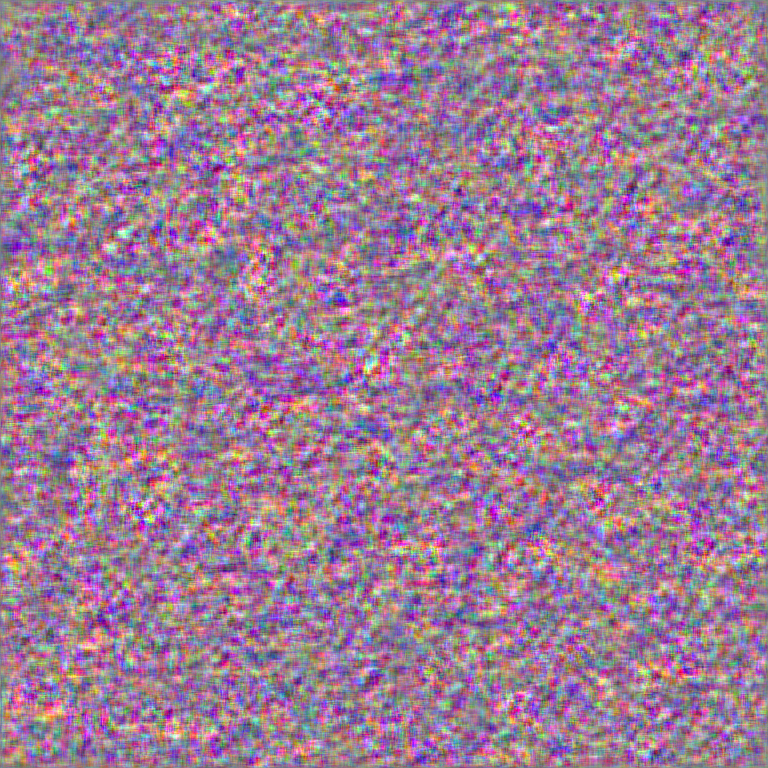

In [16]:
Image.fromarray(cu.create_image_grid(samples))

___

In [ ]:
assert False

In [20]:
samples, controls = cu.get_sdxl_sample(
    guidance=edges,
    ddim_steps=10,
    num_samples=num_samples,
    model=model,
    shape=[4, size // 8, size // 8],
    control_scale=0.95,
    prompt=prompt,
    n_prompt='lowres, bad anatomy, worst quality, low quality',
)

Global seed set to 1999158951


[CONTROL CORRECTION OF ControlledDiffusionEngine SCALED WITH 0.95]


In [21]:
Image.fromarray(cu.create_image_grid(samples)).save('SDXL_Shoe.png')